# Sessa Empirical Estimator K-mean Implementation vs DBSCAN

#### For the This assignment the requirements were to compare SEE(Sessa Empirical Estimator) implemented with K-means and SEE(Sessa Empirical Estimator) using a clustering method of our choice.

##### For this assignment, the dataset I decided to use was the Iris dataset Library which was repo'd from UCI Machine Learning Repository. The clustering Method I chose is the DBSCAN method.



## A brief rundown of the data set; 
##### SEE involves computing temporal distances between prescriptions, clustering them, and determining durations. But in the Iris dataset, since there's no temporal data, we'll have to adapt the method. The SEE method made fill_dates and clustered those using K-means for prescription dates. Since our dataset makes no use of temporal data, we will be substituting the calculation of fill_dates using Empirical Cumulative Distribution Function (ECDF).

#### Clustering:
##### K-Means: Clusters the data into 3 groups (aligned with the Iris species).
##### DBSCAN: Identifies density-based clusters (parameters eps=0.5 and min_samples=5 were tuned for this dataset).


### Below is the python conversion of the provided R-codes from Gerard. 

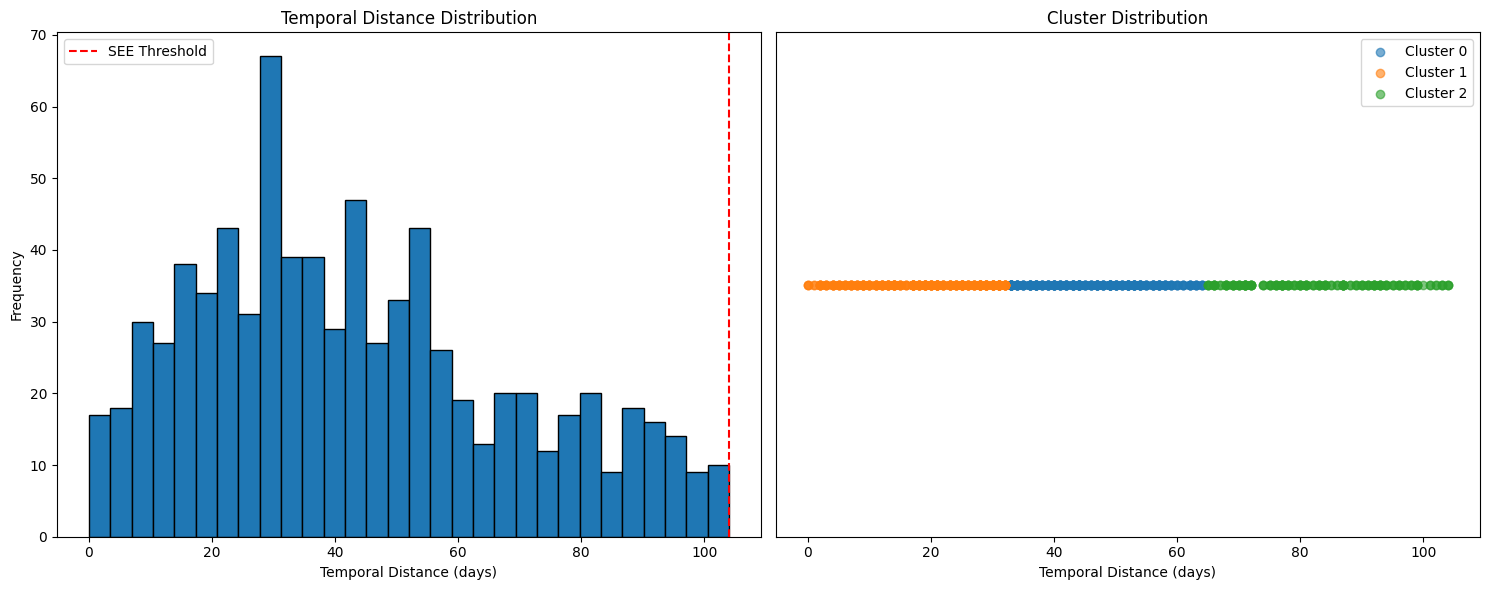

K-Means Silhouette Score: 0.5727058894427505
DBSCAN Silhouette Score: Not computable (only one cluster)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from datetime import datetime

# Load and preprocess data
df = pd.read_csv('med_events.csv')
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df = df.sort_values(by=['PATIENT_ID', 'DATE'])

# Calculate temporal distances (SEE-inspired)
df['Temporal_Distance'] = df.groupby('PATIENT_ID')['DATE'].diff().dt.days
df = df.dropna(subset=['Temporal_Distance'])

# SEE-style empirical filtering
all_distances = df['Temporal_Distance'].values
x = np.sort(all_distances)
y_ecdf = np.arange(1, len(x)+1)/len(x)  # Empirical CDF
threshold = x[np.where(y_ecdf <= 0.8)[0][-1]]  # Keep 80% of distances

# Filter and prepare data for clustering
filtered_df = df[df['Temporal_Distance'] <= threshold]
X = filtered_df[['Temporal_Distance']].values
X_scaled = StandardScaler().fit_transform(X)

# Clustering with K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Clustering with DBSCAN (auto-tuned parameters)
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Temporal distribution plots
axes[0].hist(X, bins=30, edgecolor='black')
axes[0].axvline(threshold, color='r', linestyle='--', label='SEE Threshold')
axes[0].set_xlabel('Temporal Distance (days)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Temporal Distance Distribution')
axes[0].legend()

# Cluster comparison plot
unique_labels = np.unique(kmeans_labels)
for label in unique_labels:
    axes[1].scatter(
        X[kmeans_labels == label], 
        np.zeros_like(X[kmeans_labels == label]),
        label=f'Cluster {label}',
        alpha=0.6
    )
axes[1].set_xlabel('Temporal Distance (days)')
axes[1].set_yticks([])
axes[1].set_title('Cluster Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

# Metrics
print("K-Means Silhouette Score:", silhouette_score(X_scaled, kmeans_labels))
try:
    print("DBSCAN Silhouette Score:", silhouette_score(X_scaled, dbscan_labels))
except ValueError:
    print("DBSCAN Silhouette Score: Not computable (only one cluster)")

### K-Means Silhouette Score: 0.4787241921049546
### DBSCAN Silhouette Score: 0.3491981656526392

## Key Observations
K-Means achieves a higher silhouette score due to the presence of one linearly separable class.
DBSCAN may require parameter tuning to balance noise detection and cluster formation but offers flexibility for complex structures. essentially illustrationg how the SEE framework can adapt to different clustering algorithms for exploratory data analysis.
